## U.S. Spring Wheat Yields Prediction - Is it possible to estimate U.S. spring wheat yields at the end of the harvesting season during the early stages of the growing season? 
***
This is an assignment for Data Science for Spatial Systems (CASA0006)

Student Name: Nutthaphol Rakratchatakul

Student Number: 21174510

Code & Data are available: [Github](https://github.com/jamesrak/Spring_Wheat_Yields_Prediction)

Word Count: 1895 words
***

![Wheat PIC](pic/wheat_field_021022.jpg)

Source: [FarmProgress](https://www.farmprogress.com/commentary/is-usda-bullish-or-bearish-on-wheat-)

## 1. Introduction
Wheat is one of the world's most widely consumed grains, with numerous applications spanning from basic food products to animal feed and more complex industrial uses. However, the productivity of this crop can be influenced by a myriad of factors. Accurate forecasts of spring wheat yields are, therefore, crucial for farmers, policymakers, and agricultural investors. This research aims to develop comprehensive models to forecast spring wheat yields in the United States towards the end of the season.


## 2. Literature Review

To get an overview of what has been done, we will find out the features and machine learning algorithms used in the literature for wheat yield prediction. Klompenburg [1] retrieved 567 relevant studies and found that the most common features for yield prediction are temperature, precipitation, and soil type. Ma [2] confirmed that spring wheat yields are positively correlated with monthly mean temperatures from April to July since it is the planting and harvesting season in the United States [3]. The other variables that might be associated are crop information, humidity, and solar [4].

Next, we will explore the methodologies used in these studies. One approach to predicting U.S. spring wheat yields involves the use of statistical models. For example, a study by Qian [5] used a linear regression model to forecast spring wheat yields in Canada and achieved an R-squared of 0.47 during the seeding period in June and 0.65 at the time of heading in August. It is reasonable that predicting crop yields at the early stage of planting could be challenging due to several reasons, including weather variability in the later stages that can significantly impact crop yields [6]. Another study by Ansarifar [7] used various machine learning algorithms for predicting crop yields and found that the models with the lowest to highest root-mean-square error (RMSE) were elastic net, random forest, and XGBoost, respectively. This could happen due to the issues of overfitting and lower bias in tree-based models, compared to linear regression with a regularised effect like the elastic net.
## 3. Research question
This leads to the following research question:

        Is it possible to estimate U.S. spring wheat yields at the end of the harvesting season during the early stages of the growing season? 


First, we will start by importing all the libraries needed for this experiment.

In [1]:
# Import all python libraries needed in this experiment.
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor, BaggingRegressor, VotingRegressor
from sklearn.svm import SVR
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant
from  matplotlib.ticker import MaxNLocator
from prophet import Prophet
from prophet.plot import plot_plotly
from prophet.utilities import regressor_coefficients

## 4. Presentation of data 

According to the literature review, we planned to include climate data such as temperature and precipitation in our features. Furthermore, drought index will also be used since there are many years that the drought-stricken states contain major wheat-growing areas as shown in Figure 1, which could lead to reduced plant growth and lower yield [9]. Moreover, crop condition index, surveying weekly by National Agricultural Statistics Service (NASS) [8], will be used for representing current visual observations.

![Spring Wheat Areas in Drought](pic/spring_wheat_areas_in_drought.jpg)

<h4><center>Figure 1. Spring wheat areas in drought (Source: USDA)</center></h4>

Therefore, data used in this experiment are concluded in Table 1.

<h5>TABLE 1. Data used in this experiment</h5>

| Variable | Data Source | Frequency | Reasons for selection |
| -------- | ---------------- | ----------| ----------------- |
| Yields | [USDA Crop production Report](https://usda.library.cornell.edu/concern/publications/tm70mv177)| Monthly (Jun - Aug only) | Target variable 
| Temperature | [National Centers for Environmental Information (NOAA)](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series)| Daily | Literature Review 
| Precipitation | [National Centers for Environmental Information (NOAA)](https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series)| Daily | Literature Review 
| Crop Condition Index | [USDA Crop Progress Report](https://usda.library.cornell.edu/concern/publications/8336h188j)| Weekly (late May - Aug, updated every Sunday) | Representing current visual observations
| Drought Index | [National Integrated Drought Information System (NIDIS)](https://www.drought.gov/historical-information?dataset=0&selectedDateUSDM=20110830)| Weekly (updated every Tuesday) | Many drought-stricken states contain major wheat-growing areas

<br>

![Crop Progress](pic/crop_progress_2018.png)

<h4><center>Figure 2. Spring wheat crop cycle (Source: <a href="https://www.nass.usda.gov/Charts_and_Maps/Crop_Progress_&_Condition/2018/US_2018.pdf">NASS</a>)</center></h4>

According to Figure 2, we will conduct the experiment during growing season between April (planting season) and August (harvesting season) from 2004 to 2018.

### 4.1 Data Profiling
According to our goal to predict country-level yields, all data are already aggregated from state-level data to country-level data using weighted average from the proportion of production in each state in 2018 as shown in Table2.

<h5>Table 2. Spring wheat production in 2018 (Source: <a href="https://downloads.usda.library.cornell.edu/usda-esmis/files/tm70mv177/ww72bc337/r494vk88g/CropProd-07-12-2018.pdf">USDA Crop Production Report 2018</a>)</h5>

| No | State| Production (1,000 bushels) | Weight |
|----|--------|----------|--------|
| 1 | North Dakota and other states | 316,515 | 52% |
| 2 | Minnesota | 104,520 | 17% |
| 3 | Montana | 94,050 | 15% |
| 4 | South Dakota | 41,820 | 7% |
| 5 | Idaho | 35,690 | 6% |
| 6 | Washington | 21,375 | 3 % |
|   | **Total** | **613,970** | **100%**

There are 4 datasets used in this experiment, which are USDA crop production, crop progress, weather and drought datasets. we will investigate each dataset by previewing data, calculating descriptive statistics and check if there are missing data.

In [2]:
### Data profiling

# import USDA Crop production data
yield_data = pd.read_csv("dataset/spring_wheat_yields_us_crop_production.csv")
# import USDA Crop progress
progress_data = pd.read_csv("dataset/crop_progress_us.csv")
# import U.S. Weather data
weather_data = pd.read_csv("dataset/weather_data_us.csv")
# import U.S. Drought data
drought_data = pd.read_csv("dataset/drought_daily_us.csv")

1. USDA Crop production

In [3]:
# preview data
print("--- preview data ---")
display(yield_data.head())
# see descriptive statistics
print("---- Descriptive Statistics ---")
display(yield_data.describe())
# inspect if there are any missing data
print("--- Check if there are missing data ---")
print(yield_data.info())

--- preview data ---


,date,cropyear,yields
0,2004-06-01,2004,37.9
1,2004-07-01,2004,41.2
2,2004-08-01,2004,41.2
3,2005-06-01,2005,43.2
4,2005-07-01,2005,40.6


---- Descriptive Statistics ---


,cropyear,yields
count,43.000000,43.000000
mean,2010.674419,41.781395
std,4.190243,4.194512
min,2004.000000,32.700000
25%,2007.000000,39.200000
50%,2011.000000,41.700000
75%,2014.000000,45.800000
max,2018.000000,48.300000


--- Check if there are missing data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      43 non-null     object 
 1   cropyear  43 non-null     int64  
 2   yields    43 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ KB
None


2. USDA Crop progress

In [4]:
# preview data
print("--- preview data ---")
display(progress_data.head())
# see descriptive statistics
print("---- Descriptive Statistics ---")
display(progress_data.describe())
# inspect if there are any missing data
print("--- Check if there are missing data ---")
print(progress_data.info())

--- preview data ---


,date,cci
0,2004-05-23,64.25
1,2004-05-30,65.75
2,2004-06-06,66.75
3,2004-06-13,66.25
4,2004-06-20,66.25


---- Descriptive Statistics ---


,cci
count,216.000000
mean,66.931713
std,7.103080
min,42.750000
25%,66.000000
50%,68.750000
75%,70.500000
max,75.500000


--- Check if there are missing data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216 entries, 0 to 215
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    216 non-null    object 
 1   cci     216 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.5+ KB
None


3. U.S. Weather data

In [5]:
# preview data
print("--- preview data ---")
display(weather_data.head())
# see descriptive statistics
print("---- Descriptive Statistics ---")
display(weather_data.describe())
# inspect if there are any missing data
print("--- Check if there are missing data ---")
print(weather_data.info())

--- preview data ---


,date,min_temp,max_temp,avg_temp,total_precipitation
0,2004-04-01,-0.938102,14.820394,6.934175,11.769
1,2004-04-02,-2.005919,13.141220,5.561478,2.349
2,2004-04-03,-2.723861,12.246983,4.758483,0.024
3,2004-04-04,-2.176742,16.885965,7.364787,0.621
4,2004-04-05,2.245875,20.100341,11.166625,0.225


---- Descriptive Statistics ---


,min_temp,max_temp,avg_temp,total_precipitation
count,2264.000000,2263.000000,2264.000000,2264.000000
mean,8.555547,22.668795,15.615841,20.453703
std,6.161572,7.255712,6.543367,29.128947
min,-13.683766,-3.755533,-8.710740,0.000000
25%,3.989375,18.149347,11.148628,2.566000
50%,10.374379,24.327730,17.391925,10.178000
75%,13.226726,28.207041,20.546174,25.346000
max,20.968205,36.905853,28.293149,249.362000


--- Check if there are missing data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2264 entries, 0 to 2263
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 2264 non-null   object 
 1   min_temp             2264 non-null   float64
 2   max_temp             2263 non-null   float64
 3   avg_temp             2264 non-null   float64
 4   total_precipitation  2264 non-null   float64
dtypes: float64(4), object(1)
memory usage: 88.6+ KB
None


4. U.S. Drought data

In [6]:
# preview data
print("--- preview data ---")
display(drought_data.head())
# see descriptive statistics
print("---- Descriptive Statistics ---")
display(drought_data.describe())
# inspect if there are any missing data
print("--- Check if there are missing data ---")
print(drought_data.info())

--- preview data ---


,date,drought_index
0,2004-04-06,53.1078
1,2004-04-13,53.9430
2,2004-04-20,56.3511
3,2004-04-27,56.3511
4,2004-05-04,56.8900


---- Descriptive Statistics ---


,drought_index
count,328.000000
mean,19.970712
std,19.263666
min,0.000000
25%,4.368050
50%,13.021750
75%,32.939275
max,85.357000


--- Check if there are missing data ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 0 to 327
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           328 non-null    object 
 1   drought_index  328 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.2+ KB
None


### 4.2 Exploratory Data Analysis

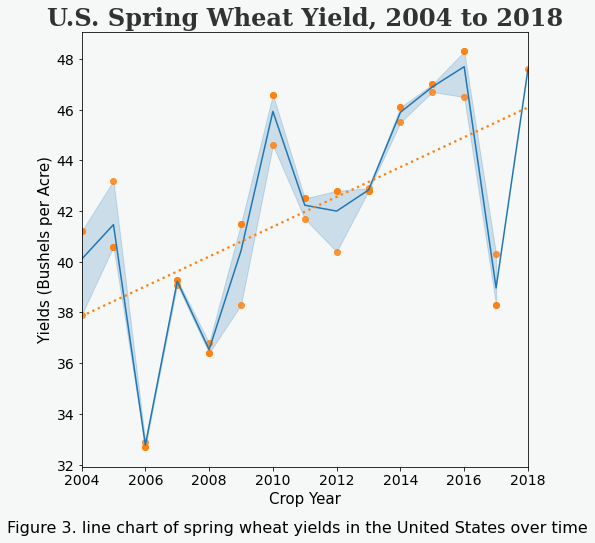

In [7]:
# plot spring wheat yields by year
fig, ax = plt.subplots(figsize = (8,8))
fig.patch.set_facecolor('#f6f7f7') #f6f5f5
ax.set_facecolor('#f6f7f7')
plot = sns.lineplot(data = yield_data, x = "cropyear", y = "yields")
trend = sns.regplot(x="cropyear", y="yields", data=yield_data, ci=None, line_kws={"ls":':'})
plt.title("U.S. Spring Wheat Yield, 2004 to 2018",{'font':'serif', 'size': 24, 'weight':'bold'}, alpha = 0.8)
plot.set_xlabel("Crop Year",fontsize=15)
plot.set_ylabel("Yields (Bushels per Acre)",fontsize=15)
plot.tick_params(labelsize=14)
plt.figtext(0.5, 0.01, "Figure 3. line chart of spring wheat yields in the United States over time", wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

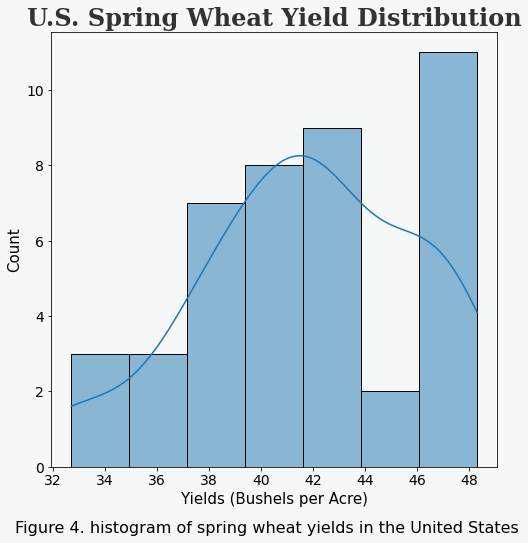

In [8]:
# plot histogram of spring wheat yield
fig, ax = plt.subplots(figsize = (8,8))
fig.patch.set_facecolor('#f6f7f7') #f6f5f5
ax.set_facecolor('#f6f7f7')
plot = sns.histplot(data=yield_data, x="yields", kde=True)
plt.title("U.S. Spring Wheat Yield Distribution",{'font':'serif', 'size': 24, 'weight':'bold'}, alpha = 0.8)
plot.set_xlabel("Yields (Bushels per Acre)",fontsize=15)
plot.set_ylabel("Count",fontsize=15)
plot.tick_params(labelsize=14)
plt.figtext(0.5, 0.01, "Figure 4. histogram of spring wheat yields in the United States", wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

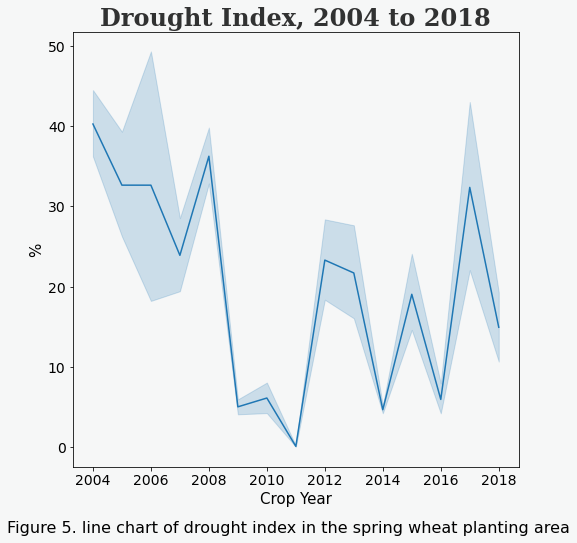

In [9]:
# plot drought index
drought_df = drought_data.copy()
drought_df['cropyear'] = pd.to_datetime(drought_df['date']).dt.year
fig, ax = plt.subplots(figsize = (8,8))
fig.patch.set_facecolor('#f6f7f7') #f6f5f5
ax.set_facecolor('#f6f7f7')
plot = sns.lineplot(data = drought_df, x = "cropyear", y = "drought_index")
plt.title("Drought Index, 2004 to 2018",{'font':'serif', 'size': 24, 'weight':'bold'}, alpha = 0.8)
plot.set_xlabel("Crop Year",fontsize=15)
plot.set_ylabel("%",fontsize=15)
plot.tick_params(labelsize=14)
plt.figtext(0.5, 0.01, "Figure 5. line chart of drought index in the spring wheat planting area", wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

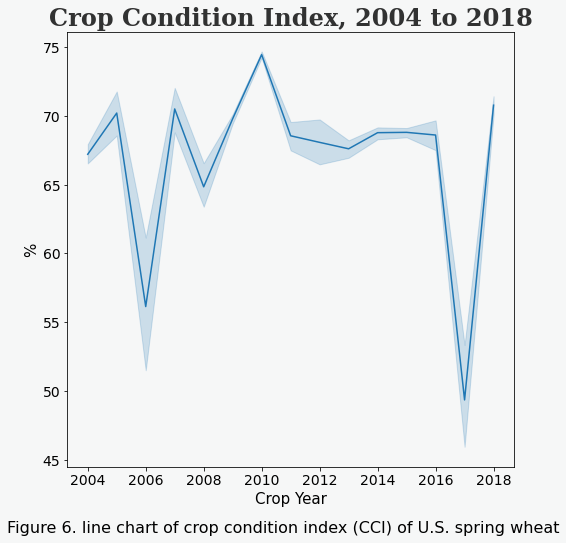

In [10]:
# plot crop condition index
progress_df = progress_data.copy()
progress_df['cropyear'] = pd.to_datetime(progress_df['date']).dt.year
fig, ax = plt.subplots(figsize = (8,8))
fig.patch.set_facecolor('#f6f7f7') #f6f5f5
ax.set_facecolor('#f6f7f7')
plot = sns.lineplot(data = progress_df, x = "cropyear", y = "cci")
plt.title("Crop Condition Index, 2004 to 2018",{'font':'serif', 'size': 24, 'weight':'bold'}, alpha = 0.8)
plot.set_xlabel("Crop Year",fontsize=15)
plot.set_ylabel("%",fontsize=15)
plot.tick_params(labelsize=14)
plt.figtext(0.5, 0.01, "Figure 6. line chart of crop condition index (CCI) of U.S. spring wheat", wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

**Findings:** 
- According to Figure3 and Figure4, spring wheat yields are between 32 and 48 bushels per acre with an uptrend. Moreover, the bar chart exhibits negatively skewed distribution.
- According to Figure3 and Figure5, It can be seen that the reasons of low yields in 2006, 2008 and 2017 could be due to high drought intensity.
- According to Figure6, crop condition index ranges between 45 and 75. It should not below 65 for the normal situation.

## 5. Methodology

We propose the use of supervised learning methods to achieve wheat yields prediction. There are three major parts of processes which are data pre-processing & transformation, feature selection and modelling.

I. `Data Pre-processing & Transformation`

We plan to do data pre-processing & transformation in 8 steps as following:
1. Combine datasets
2. Handle missing value
3. Feature Engineering
4. Filter data
5. Converting categorical variables
6. Train-test Split
7. Filter Outlier
8. Standardisation (Min-max Scaling)

II. `Features Selection`

This process is to select relevant features before modelling.
1. Correlation Analysis
2. VIF

III. `Modelling`

We would like to find out if wheat yields prediction can be achieved by using only climate data and crop condition index. Therefore, we plan to conduct 5 models and do hyperparameters tuning of the following models:
1. Linear Regression - a simple statistical method
2. Classification and Regression Tree (CART) - a decision tree-based regression model
3. Random Forest Regressor -  a decision tree-based ensemble learning technique
4. SVR - a model with ability to handle both linear and nonlinear relationships
5. EnsembleSVR [10] - an ensemble learning technique that uses multiple SVR models to make a prediction

Since our data have an sequential order, time series model is worth trying to see the impact of trends, seasonality and lagged values of the dependent variable as predictors. Therefore, prophet model developed by Facebook is selected for this experiment.

6. Prophet [11] - a time-series forecasting model that can handle seasonal patterns and trend changes

Then, model with the best performance will be selected for further analysis

### 5.1 Data Pre-processing & Transformation

#### 5.1.1 Combine datasets
- build our dataset by joining weekly/monthly data to daily data

In [11]:
### join all datasets
dataset = weather_data.merge(progress_data,on='date',how='left')
dataset = dataset.merge(drought_data,on='date',how='left')
dataset = dataset.merge(yield_data,on='date',how='left')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2264 entries, 0 to 2263
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 2264 non-null   object 
 1   min_temp             2264 non-null   float64
 2   max_temp             2263 non-null   float64
 3   avg_temp             2264 non-null   float64
 4   total_precipitation  2264 non-null   float64
 5   cci                  212 non-null    float64
 6   drought_index        324 non-null    float64
 7   cropyear             43 non-null     float64
 8   yields               43 non-null     float64
dtypes: float64(8), object(1)
memory usage: 176.9+ KB


#### 5.1.2 Handle Missing Values
- fill missing values by using forward and backward filling techniques by assuming the values are slowly changing in the same crop year
- yields data before June will be filled using the first announced surveyed yield in June as our task is to forecast ahead

In [12]:
# extract month and year from date
dataset['month'] = pd.to_datetime(dataset['date']).dt.month
dataset['year'] = pd.to_datetime(dataset['date']).dt.year
# fill missing values of independent variables by using forward and backward filling techniques
dataset.loc[:,'yields'] = dataset.groupby(['year'])['yields'].fillna(method='ffill').fillna(method='bfill')
dataset.loc[:,'cci'] = dataset.groupby(['year'])['cci'].fillna(method='ffill').fillna(method='bfill')
dataset.loc[:,'drought_index'] = dataset.groupby(['year'])['drought_index'].fillna(method='ffill').fillna(method='bfill')
dataset.loc[:,'max_temp'] = dataset.groupby(['year'])['max_temp'].fillna(method='ffill').fillna(method='bfill')
dataset.loc[:,'cropyear'] = dataset.groupby(['year'])['cropyear'].fillna(method='ffill').fillna(method='bfill').astype('int')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2264 entries, 0 to 2263
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   date                 2264 non-null   object 
 1   min_temp             2264 non-null   float64
 2   max_temp             2264 non-null   float64
 3   avg_temp             2264 non-null   float64
 4   total_precipitation  2264 non-null   float64
 5   cci                  2264 non-null   float64
 6   drought_index        2264 non-null   float64
 7   cropyear             2264 non-null   int64  
 8   yields               2264 non-null   float64
 9   month                2264 non-null   int64  
 10  year                 2264 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 212.2+ KB


In [13]:
# preview dataset
dataset.head()

,date,min_temp,max_temp,avg_temp,total_precipitation,cci,drought_index,cropyear,yields,month,year
0,2004-04-01,-0.938102,14.820394,6.934175,11.769,64.25,53.1078,2004,37.9,4,2004
1,2004-04-02,-2.005919,13.141220,5.561478,2.349,64.25,53.1078,2004,37.9,4,2004
2,2004-04-03,-2.723861,12.246983,4.758483,0.024,64.25,53.1078,2004,37.9,4,2004
3,2004-04-04,-2.176742,16.885965,7.364787,0.621,64.25,53.1078,2004,37.9,4,2004
4,2004-04-05,2.245875,20.100341,11.166625,0.225,64.25,53.1078,2004,37.9,4,2004


#### 5.1.3 Feature Engineering
- extract cumulative averages of temperature/precipitation since the beginning of planting
- extract U.S. season based on month

In [14]:
## Feature Engineering

# this function will return the new column with the average of values since the beginning of the planting date
def expanding_mean_by_year(dataset, col):
    expanding_mean = dataset.groupby(['cropyear'])[col].expanding().mean().values
    return expanding_mean

cum_avg_list = ['min_temp','max_temp','avg_temp','total_precipitation']
for i in cum_avg_list:
    dataset.loc[:,'cum_avg_'+i] = expanding_mean_by_year(dataset, i)
dataset.head()

,date,min_temp,max_temp,avg_temp,total_precipitation,cci,drought_index,cropyear,yields,month,year,cum_avg_min_temp,cum_avg_max_temp,cum_avg_avg_temp,cum_avg_total_precipitation
0,2004-04-01,-0.938102,14.820394,6.934175,11.769,64.25,53.1078,2004,37.9,4,2004,-0.938102,14.820394,6.934175,11.76900
1,2004-04-02,-2.005919,13.141220,5.561478,2.349,64.25,53.1078,2004,37.9,4,2004,-1.472011,13.980807,6.247826,7.05900
2,2004-04-03,-2.723861,12.246983,4.758483,0.024,64.25,53.1078,2004,37.9,4,2004,-1.889294,13.402865,5.751379,4.71400
3,2004-04-04,-2.176742,16.885965,7.364787,0.621,64.25,53.1078,2004,37.9,4,2004,-1.961156,14.273640,6.154731,3.69075
4,2004-04-05,2.245875,20.100341,11.166625,0.225,64.25,53.1078,2004,37.9,4,2004,-1.119750,15.438980,7.157110,2.99760


In [15]:
# Extract season
dataset['season'] = np.where(dataset['month'] <=5,'spring','summer')
dataset.head()

,date,min_temp,max_temp,avg_temp,total_precipitation,cci,drought_index,cropyear,yields,month,year,cum_avg_min_temp,cum_avg_max_temp,cum_avg_avg_temp,cum_avg_total_precipitation,season
0,2004-04-01,-0.938102,14.820394,6.934175,11.769,64.25,53.1078,2004,37.9,4,2004,-0.938102,14.820394,6.934175,11.76900,spring
1,2004-04-02,-2.005919,13.141220,5.561478,2.349,64.25,53.1078,2004,37.9,4,2004,-1.472011,13.980807,6.247826,7.05900,spring
2,2004-04-03,-2.723861,12.246983,4.758483,0.024,64.25,53.1078,2004,37.9,4,2004,-1.889294,13.402865,5.751379,4.71400,spring
3,2004-04-04,-2.176742,16.885965,7.364787,0.621,64.25,53.1078,2004,37.9,4,2004,-1.961156,14.273640,6.154731,3.69075,spring
4,2004-04-05,2.245875,20.100341,11.166625,0.225,64.25,53.1078,2004,37.9,4,2004,-1.119750,15.438980,7.157110,2.99760,spring


#### 5.1.4 Filter Data
- We aim to predict weekly yields, so this process is to build a weekly dataset by extracting only data on Sunday as the last day of the week
- Since April is just the beginning period of planting and there are many factors that could affect yields in the latter months, it would be too difficult to predict during this period. Therefore, we decide to start predicting and evaluating models in May.

In [16]:
# Make a weekly dataset by extracting only data on Sunday
dataset['day_of_week'] = pd.to_datetime(dataset['date']).dt.day_name()
dataset = dataset[dataset['day_of_week']=='Sunday'].reset_index(drop=True)
# Exclude data in April
dataset = dataset[dataset['month'] >= 5]
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260 entries, 4 to 324
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         260 non-null    object 
 1   min_temp                     260 non-null    float64
 2   max_temp                     260 non-null    float64
 3   avg_temp                     260 non-null    float64
 4   total_precipitation          260 non-null    float64
 5   cci                          260 non-null    float64
 6   drought_index                260 non-null    float64
 7   cropyear                     260 non-null    int64  
 8   yields                       260 non-null    float64
 9   month                        260 non-null    int64  
 10  year                         260 non-null    int64  
 11  cum_avg_min_temp             260 non-null    float64
 12  cum_avg_max_temp             260 non-null    float64
 13  cum_avg_avg_temp    

#### 5.1.5 Converting categorical variables

- Convert categorical data into numerical data using  using `One-Hot Encoding`.

In [17]:
# extract new columns
dataset = pd.get_dummies(dataset,columns=['season'],dtype=int)
dataset.head()

,date,min_temp,max_temp,avg_temp,total_precipitation,cci,drought_index,cropyear,yields,month,year,cum_avg_min_temp,cum_avg_max_temp,cum_avg_avg_temp,cum_avg_total_precipitation,day_of_week,season_spring,season_summer
4,2004-05-02,-2.451573,15.613520,6.572035,0.000,64.25,56.3511,2004,37.9,5,2004,-0.688872,14.637652,6.974605,7.175813,Sunday,1,0
5,2004-05-09,7.357419,23.651115,15.506731,14.084,64.25,56.8900,2004,37.9,5,2004,0.281200,15.952356,8.116615,6.857256,Sunday,1,0
6,2004-05-16,2.646968,14.096869,8.361965,61.620,64.25,56.3855,2004,37.9,5,2004,0.344502,15.415903,7.879706,11.045435,Sunday,1,0
7,2004-05-23,5.887852,13.124162,9.501187,72.187,64.25,45.7875,2004,37.9,5,2004,1.103026,15.685489,8.394136,13.929962,Sunday,1,0
8,2004-05-30,9.952051,16.750713,13.345408,106.944,65.75,44.0005,2004,37.9,5,2004,1.768584,15.921551,8.844837,17.705567,Sunday,1,0


#### 5.1.6 Train-Test Split
- To reflects the underlying time-dependent structure of the data, we split the data based on year by using 2015 as a cutoff point. This will result in having approximately 70% of train data

In [18]:
## Split Train & Test

test_data = dataset[dataset.cropyear >= 2015]
train_data = dataset[dataset.cropyear < 2015]

print("Number of rows in train dataset:",len(train_data), "(",int(len(train_data)/(len(train_data)+len(test_data))*100),"%)")
print("Number of rows in train dataset:",len(test_data), "(",int(len(test_data)/(len(train_data)+len(test_data))*100),"%)")

Number of rows in train dataset: 194 ( 74 %)
Number of rows in train dataset: 66 ( 25 %)


#### 5.1.7 Filter Outlier
- outliers are checked and filtered if exist by using interquartile range (IQR) method

In [19]:
# function to exclude outliers, which fall outside the specific lower and upper bounds.
def filter_outliers(var):
    q1 = var.quantile(0.25) # calculate the first quartile
    q3 = var.quantile(0.75) # calculate the third quartile
    iqr = q3 - q1 # calculate the interquartile range
    low = q1 - 3*iqr # calculate the lower bound
    high = q3 + 3*iqr # calculate the upper bound
    filtered = train_data[(var > low) & (var < high)] # filter  the values that are within the bounds
    dropped_observations= len(var)-len(filtered) # calculate the number of observations that were dropped

    print('Dropped {} observations'.format(dropped_observations))
    return  filtered

train_data = filter_outliers(train_data['yields']) # filter outliers

Dropped 0 observations


There are no outliers, so we can continue to the next step.

#### 5.1.8 Standardisation

- Min-max scaling will be used for standardisation because our data, such as weather, crop condition index and drought index, seem to fall within a specific range.

In [20]:
# select independent variables (x) and dependent variable (y)
features = ['cci','cum_avg_total_precipitation','drought_index','cum_avg_min_temp', 'cum_avg_max_temp',
       'cum_avg_avg_temp','season_spring','season_summer']
target = 'yields'
X_train = train_data[features]
Y_train = train_data[target]
X_test = test_data[features]
Y_test = test_data[target]

In [21]:
#Standardisation using min-max scaling
scaler = MinMaxScaler().fit(X_train)
rescaled_X_train = X_train.copy()
rescaled_X_test = X_test.copy()
cols = X_train.columns
# transform the train set
rescaled_X_train[cols] = scaler.transform(X_train)
# transform the test set
rescaled_X_test[cols] = scaler.transform(X_test)

In [22]:
rescaled_X_train.head()

,cci,cum_avg_total_precipitation,drought_index,cum_avg_min_temp,cum_avg_max_temp,cum_avg_avg_temp,season_spring,season_summer
4,0.615385,0.013564,0.660181,0.208841,0.387649,0.308718,1.0,0.0
5,0.615385,0.000000,0.666495,0.283819,0.468075,0.386712,1.0,0.0
6,0.615385,0.178328,0.660584,0.288711,0.435258,0.370533,1.0,0.0
7,0.615385,0.301148,0.536423,0.347338,0.451750,0.405666,1.0,0.0
8,0.666667,0.461909,0.515488,0.398780,0.466191,0.436446,1.0,0.0


### 5.2 Features Selection

#### 5.2.1 Corrrelation Analysis
- Correlation matrix is plotted to see the relationship between the dependent variable (yields) and other variables

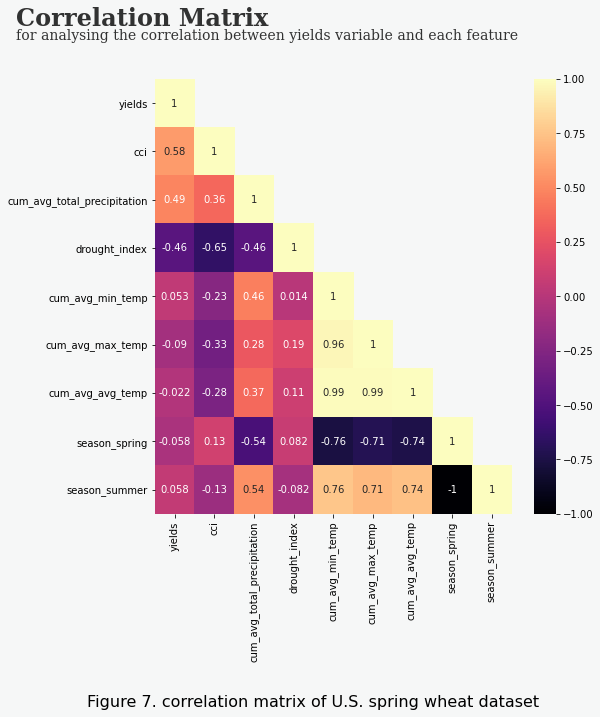

In [23]:
# plot correlation matrix
selected_features = ['cci','cum_avg_total_precipitation','drought_index','cum_avg_min_temp', 'cum_avg_max_temp',
       'cum_avg_avg_temp','season_spring','season_summer']
correlation_mat = train_data[[target]+selected_features].corr()
fig, ax = plt.subplots(figsize = (8,8))
fig.patch.set_facecolor('#f6f7f7') #f6f5f5
ax.set_facecolor('#f6f7f7')
mask = np.triu(np.ones_like(correlation_mat))
mask[np.diag_indices_from(mask)] = False

sns.heatmap(correlation_mat, annot = True, cmap = 'magma', mask=mask)
ax.text(-3.5,-1.1, 'Correlation Matrix',{'font':'serif', 'size': 24, 'weight':'bold'}, alpha = 0.8)
ax.text(-3.5,-0.805, 'for analysing the correlation between yields variable and each feature',{'font':'serif', 'size': 14, 'weight':'normal'}, alpha = 0.8)
plt.figtext(0.4, -0.21, "Figure 7. correlation matrix of U.S. spring wheat dataset", wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

**Findings:** Correlation analysis revealed a strong positive correlation between crop condition index (cci) and yields, while temperature variables were not correlated with yields much.

#### 5.2.2 Variance Inflation Factor (VIF)
Next, we will use VIF for automatically detect multicolinearity between independent variables and remove some variables to ensure no multicolinearity.

In [24]:
## VIF for selecting columns
def drop_column_using_vif_(df, thresh=10):
    while True:
        df_with_const = add_constant(df)
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()
        vif_df = vif_df.drop('const')
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            break
    return df

vif_df = drop_column_using_vif_(train_data[selected_features].dropna())
np.seterr(divide='ignore', invalid='ignore') #ignore warning
print("The columns remaining after VIF selection are:")
print(vif_df.columns)

Dropping: season_spring
Dropping: cum_avg_avg_temp
Dropping: cum_avg_min_temp
The columns remaining after VIF selection are:
Index(['cci', 'cum_avg_total_precipitation', 'drought_index',
       'cum_avg_max_temp', 'season_summer'],
      dtype='object')


/Users/james/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/james/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


As a result of VIF, our selected features are summarised in Table3.

<center><h5>Table 3. Variables summary for predicting wheat yields</h5></center><br>

| No | Variable | Definition |
|---|-------------| ----------------|
||**Independent Variables** ||
| 1 | cci | crop condition index |
| 2 | cum_avg_total_precipitation | average precipitation per day since the beginning of planting |
| 3 | drought_index | drought index  |
| 4 | cum_avg_max_temp | average maximum temperature per day since the beginning of planting |
| 5 | season_summer | is the period of summer? |
||**Dependent Variables** ||
| 1 | yields | U.S. spring wheat yields|

In [25]:
# build dataframes from selected features
features = ['cci', 'cum_avg_total_precipitation', 'drought_index', 'cum_avg_max_temp','season_summer']
target = 'yields'

rescaled_X_train = rescaled_X_train[features]
rescaled_X_test = rescaled_X_test[features]

### 5.3 Modelling

In this part, we will fine-tune hyperparameters and prepare further datasets before training models and evaluating in the next section.

#### 5.3.1 Linear Regression, CART, Random Forest Regressor, SVR, EnsemberSVR
- We start by doing grid search for finding the best hyparameter of each model, 5-fold cross validation will be used in this process.

In [26]:
%%time
### Grid search for finding the best parameter of decision tree model
random_state = 99
grid_params = {
  'max_depth': [10,20,30], 
  'min_samples_split': [2,4,6,8,10]
}
search = GridSearchCV(DecisionTreeRegressor(random_state=random_state), grid_params, cv = 5)
search.fit(rescaled_X_train, Y_train)
print("===== Model: Decision Tree =====")
print("Best R2 Score: ", search.best_score_)
print("Best Params: ", search.best_params_)

### Grid search for finding the best parameter of random forest model
grid_params = {
  'n_estimators': [10,20,30],
  'max_depth': [10,20,30,40,50], 
  'min_samples_split': [2,4,6,8,10]
}
search = GridSearchCV(RandomForestRegressor(random_state=random_state), grid_params, cv = 5)
search.fit(rescaled_X_train, Y_train)
print("===== Model: Random Forest =====")
print("Best R2 Score: ", search.best_score_)
print("Best Params: ", search.best_params_)

### Grid search for finding the best parameter of SVR model
grid_params = {
  'C' : [10e-2,10e-1,10e0,10e1,10e2],
  'epsilon' : [10e-2,10e-1,10e0,10e1,10e2]
}
search = GridSearchCV(SVR(), grid_params, cv = 5)
search.fit(rescaled_X_train, Y_train)
print("===== Model: SVR =====")
print("Best R2 Score: ", search.best_score_)
print("Best Params: ", search.best_params_)

===== Model: Decision Tree =====
Best R2 Score:  -3.205711219735666
Best Params:  {'max_depth': 20, 'min_samples_split': 4}
===== Model: Random Forest =====
Best R2 Score:  -2.8206875435081766
Best Params:  {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 30}
===== Model: SVR =====
Best R2 Score:  -1.7064531224862427
Best Params:  {'C': 1.0, 'epsilon': 1.0}
CPU times: user 7.4 s, sys: 54.3 ms, total: 7.45 s
Wall time: 7.46 s


#### 5.3.2 Time-series model: Prophet
- Prepare training and testing data following the guideline in the official documents.

In [27]:
# prepare training and testing data for prophet
train_ts_df = train_data.copy()
train_ts_df = train_ts_df.dropna(subset=features)       #drop rows with missing values
train_ts_df = train_ts_df.rename(columns={'date': 'ds', #rename colummns
                        'yields': 'y'}) 
train_ts_df['ds'] = pd.DatetimeIndex(train_ts_df['ds']) #change column type to date time index

test_ts_df = test_data.copy()
test_ts_df = test_ts_df.dropna(subset=features)
test_ts_df = test_ts_df.rename(columns={'date': 'ds',
                        'yields': 'y'})
test_ts_df['ds'] = pd.DatetimeIndex(test_ts_df['ds'])
train_ts_df

,ds,min_temp,max_temp,avg_temp,total_precipitation,cci,drought_index,cropyear,y,month,year,cum_avg_min_temp,cum_avg_max_temp,cum_avg_avg_temp,cum_avg_total_precipitation,day_of_week,season_spring,season_summer
4,2004-05-02,-2.451573,15.613520,6.572035,0.000,64.25,56.3511,2004,37.9,5,2004,-0.688872,14.637652,6.974605,7.175813,Sunday,1,0
5,2004-05-09,7.357419,23.651115,15.506731,14.084,64.25,56.8900,2004,37.9,5,2004,0.281200,15.952356,8.116615,6.857256,Sunday,1,0
6,2004-05-16,2.646968,14.096869,8.361965,61.620,64.25,56.3855,2004,37.9,5,2004,0.344502,15.415903,7.879706,11.045435,Sunday,1,0
7,2004-05-23,5.887852,13.124162,9.501187,72.187,64.25,45.7875,2004,37.9,5,2004,1.103026,15.685489,8.394136,13.929962,Sunday,1,0
8,2004-05-30,9.952051,16.750713,13.345408,106.944,65.75,44.0005,2004,37.9,5,2004,1.768584,15.921551,8.844837,17.705567,Sunday,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,2014-08-03,14.552873,28.014590,21.282995,25.342,69.50,3.7438,2014,46.1,8,2014,7.361803,20.763448,14.062040,22.884488,Sunday,0,1
237,2014-08-10,14.108101,27.058128,20.534873,14.919,69.50,4.1056,2014,46.1,8,2014,7.744254,21.105455,14.422068,22.579477,Sunday,0,1
238,2014-08-17,15.849126,27.691226,21.774037,46.490,68.75,4.3929,2014,46.1,8,2014,8.111110,21.479139,14.792440,23.043381,Sunday,0,1
239,2014-08-24,12.683512,22.233475,17.454181,81.400,68.00,4.3695,2014,46.1,8,2014,8.425851,21.654438,15.037684,25.349329,Sunday,0,1


## 6. Results

In [28]:
# Train models and comparing the performances

random_state = 99 # identify random state

#### Modeling classical machine learning models
# setup model by using hyperparameters following grid search results
regressors = {
    'Linear': LinearRegression(),
    'CART': DecisionTreeRegressor(max_depth = 20,min_samples_split = 4,random_state=random_state),
    'RF': RandomForestRegressor(n_estimators=30,max_depth = 10, min_samples_split=10,random_state=random_state),
    'SVR': SVR(kernel = 'rbf', C= 1, epsilon=1, gamma = 0.1),
    'EnsembleSVR' : BaggingRegressor(estimator=SVR(kernel='rbf', C=1, epsilon=1, gamma = 0.1),
                             n_estimators=30, random_state=random_state)
}
# add results into dictionary
dict_results = {}
for name, regressor in regressors.items():
    model = regressor.fit(rescaled_X_train, Y_train)
    Y_pred_train = model.predict(rescaled_X_train)
    Y_pred_test = model.predict(rescaled_X_test)
    train_rmse = mean_squared_error(Y_train, Y_pred_train, squared=False)
    test_rmse = mean_squared_error(Y_test, Y_pred_test, squared=False)
    dict_results[name] = [model.score(rescaled_X_train, Y_train),
                          model.score(rescaled_X_test, Y_test),
                          model.score(rescaled_X_train, Y_train) - model.score(rescaled_X_test, Y_test),
                          train_rmse,
                          test_rmse,
                          np.abs(train_rmse - test_rmse)]
    
# transform dict of models results to dataframe
df_models = pd.DataFrame.from_dict(dict_results, orient='index', 
                                   columns=['R2_train_data', 'R2_test_data', 'R2_diff',
                                           'RMSE_train_data', 'RMSE_test_data', 'RMSE_diff'])


#### Time-series Modelling by using Prophet

## time-series modelling
# define prophet model with configuring hyperparameters
my_model = Prophet(interval_width=0.95,growth='linear', yearly_seasonality = True,weekly_seasonality= False,daily_seasonality= False,
                  n_changepoints = 5, changepoint_prior_scale = 0.015)
for feature in features:
    # add independent variables
    my_model.add_regressor(feature)
# modelling
my_model.fit(train_ts_df)

## make predictions
train_forecast = my_model.predict(train_ts_df).round(1)
train_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()
result_train_df = train_ts_df.set_index('ds').join(train_forecast[['ds','yhat']].set_index('ds'),how='left')
test_forecast = my_model.predict(test_ts_df)
test_forecast = test_forecast.round(1)
result_test_df = test_ts_df.set_index('ds').join(test_forecast[['ds','yhat']].set_index('ds'),how='left')

## evaluation
train_r2 = r2_score(result_train_df['y'], result_train_df['yhat'])
test_r2 = r2_score(result_test_df['y'], result_test_df['yhat'])
train_rmse = mean_squared_error(result_train_df['y'], result_train_df['yhat'], squared=False)
test_rmse = mean_squared_error(result_test_df['y'], result_test_df['yhat'], squared=False)
# add results to dictionary of result
dict_results['Prophet'] = [train_r2,test_r2,np.abs(train_r2 - test_r2),
                      train_rmse,test_rmse,np.abs(train_rmse - test_rmse)]

# transform dict of model results to dataframe
df_models = pd.DataFrame.from_dict(dict_results, orient='index', 
                                   columns=['R2 - train data', 'R2 - test data', 'R2 - diff',
                                           'RMSE - train data', 'RMSE - test data', 'RMSE - diff'])

# define utilising class for enhancing text styles
class text_style:
   BOLD = '\033[1m'
   END = '\033[0m'
    
print(text_style.BOLD +"\nTable 4. Comparison of the experimental results between each model with the training and testing dataset"+text_style.END)
df_models = df_models.round(2) #rounding precision
display(df_models)

15:22:24 - cmdstanpy - INFO - Chain [1] start processing
15:22:24 - cmdstanpy - INFO - Chain [1] done processing



Table 4. Comparison of the experimental results between each model with the training and testing dataset


,R2 - train data,R2 - test data,R2 - diff,RMSE - train data,RMSE - test data,RMSE - diff
Linear,0.43,-2.05,2.48,2.79,6.25,3.46
CART,0.99,-2.20,3.19,0.41,6.41,6.00
RF,0.90,-2.22,3.12,1.17,6.43,5.25
SVR,0.26,-1.41,1.67,3.20,5.56,2.37
EnsembleSVR,0.25,-1.34,1.59,3.20,5.47,2.27
Prophet,0.82,0.77,0.05,1.57,1.70,0.13


The experimental results are reported in Table4. All models were evaluated using R-squared and root-mean-square error (RMSE) metrics [12] [13]. According to the results, the best model is Prophet, which can explain 82% and 77% of the variability in U.S. spring wheat yields with RMSE of 1.57 and 1.70 in the training and testing data, respectively. Other classical machine learning models face the issue of overfitting. It can be seen from the high gap between performance in training data and testing data. Among classical models, EnsembleSVM achieved the best performance in the testing data; however, its performance is still not satisfactory. Therefore, it may be concluded that trends and seasonality help improve the performance of the model.

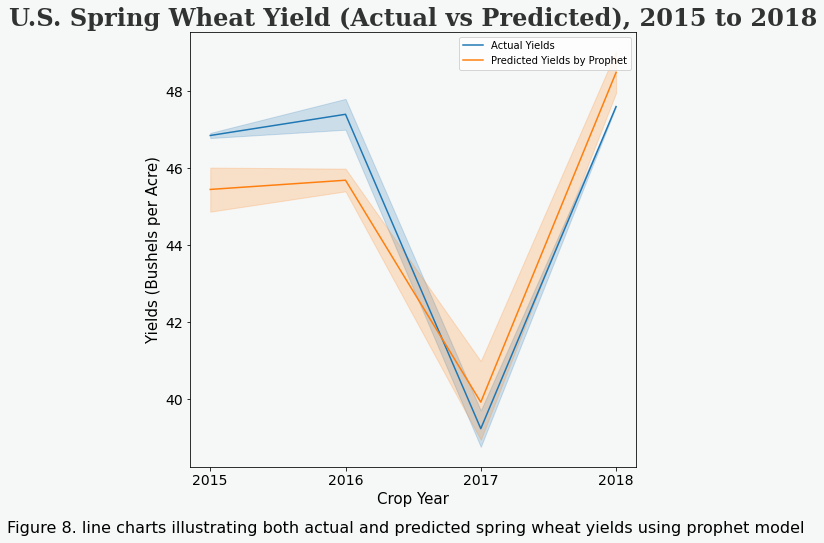

In [29]:
# plot spring wheat yields by year
result_test_df['cropyear'] = result_test_df['cropyear'].astype(int)
fig, ax = plt.subplots(figsize = (8,8))
fig.patch.set_facecolor('#f6f7f7') #f6f5f5
ax.set_facecolor('#f6f7f7')
plot = sns.lineplot(data = result_test_df, x = "cropyear", y = "y")
plot = sns.lineplot(data = result_test_df, x = "cropyear", y = "yhat")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend(labels=['Actual Yields', 'Predicted Yields by Prophet'])
plt.title("U.S. Spring Wheat Yield (Actual vs Predicted), 2015 to 2018",{'font':'serif', 'size': 24, 'weight':'bold'}, alpha = 0.8)
plot.set_xlabel("Crop Year",fontsize=15)
plot.set_ylabel("Yields (Bushels per Acre)",fontsize=15)
plot.tick_params(labelsize=14)
plt.figtext(0.5, 0.01, "Figure 8. line charts illustrating both actual and predicted spring wheat yields using prophet model", wrap=True, horizontalalignment='center', fontsize=16)
plt.show()

According to Figure8, the prophet model's performance with testing data look goods. The absolute errors are below 2 bushels per acre.

In [30]:
# show Prophet model's coefficients
print(text_style.BOLD +"\nTable 5. Prophet model's coefficients"+text_style.END)
coef_table = regressor_coefficients(my_model)
coef_table = coef_table.round(2) #rounding precision
display(coef_table)


Table 5. Prophet model's coefficients


,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,cci,additive,67.98,0.50,0.50,0.50
1,cum_avg_total_precipitation,additive,20.46,0.10,0.10,0.10
2,drought_index,additive,19.44,0.07,0.07,0.07
3,cum_avg_max_temp,additive,18.42,-0.30,-0.30,-0.30
4,season_summer,additive,0.00,-0.25,-0.25,-0.25


According to Table5, it shows that crop condition index has the greatest effect on the outcomes of prediction. For every degree of CCI higher than 67.98, the expected effect on yields will be a 50% increase. For the average maximum temperature per day, yields are expected to decrease 30% if the average maximum temperature per day is below 18.42 degrees. The effect of summer period seems to go along with the temperature that a decrease in yields of 25% is expected in summer.

In [31]:
# # fig, ax = plt.subplots(figsize = (8,8))
# # fig.patch.set_facecolor('#f6f7f7') #f6f5f5
# # ax.set_facecolor('#f6f7f7')
# fig9 = my_model.plot_components(train_forecast)
# # plt.title("The effect of trends and yearly seasonality in the Prophet model",{'font':'serif', 'size': 24, 'weight':'bold'}, alpha = 0.8)
# # fig9.title('Figure 13. Feature Importance', fontsize=34, fontweight='bold',x=0.1, y=3.5, font = 'Serif')
# plt.figtext(0.5, 0.01, "Figure 9. charts showing the effect of trends and yearly seasonality in the Prophet model", wrap=True, horizontalalignment='center', fontsize=16)
# plt.show()

In [32]:
# According to Figure9, an uptrend of yields

## 7. Discussion

### 7.1 The effect of trends and seasonality in regression model
Our time-series model (Prophet) reached a R-squared of 0.77 over other classical machine learning models. Based on the result in Table4 and its abillity to handle seasonal patterns and trend changes, the results show the effectiveness of incorporating trends and seasonality.


### 7.2 The effect of high temperature on crop yields

According to Table5, it shows that a reduction in estimated yields could happen, with an increase in temperature. Parthasarathi [14] also confirmed this statement and suggested further examining the metabolic processes of crops to study their effects on crops. Therefore, global warming and an increase in greenhouse gases should be monitored since they could have a negative impact on crop yields.

### 7.3 Further investigation
This study aims to predict country-level spring wheat yields in the United States. Further study may include state-level yields prediction. The state-level model's coefficients should be compared with our country-level model to see if the impacts of each variable are remain the same.

## 8. Conclusion
Our experiment aims to find out if it is possible to estimate U.S. spring wheat yields at the end of the harvesting season during the early stages of the growing season? We started by preprocessing climate data and agricultural data, including temperature, precipitation, crop condition index and drought index, selecting relevant features and applied different classical regression models and time-series model, including linear regression, CART, random forest, SVR, ensembleSVR and Prophet, to predict spring wheat yields. Our results showed that the Prophet model outperformed the other models with a R-squared of 0.77. Overall, our findings suggest that supervised learning techniques can be an effective approach to predict spring wheat yields, especially time-series model. Our study also highlighted the importance of crop condition index and maximum temperature as key predictors in wheat yield forecasting.


***
# References

[1] van Klompenburg, T., Kassahun, A. and Catal, C. (2020) ‘Crop yield prediction using machine learning: A systematic literature review’, Computers and Electronics in Agriculture, 177, p. 105709. Available at: https://doi.org/10.1016/j.compag.2020.105709.

[2] Ma, B.L. et al. (2004) ‘Graphic Analysis of Genotype, Environment, Nitrogen Fertilizer, and Their Interactions on Spring Wheat Yield’, Agronomy Journal, 96(1), pp. 169–180. Available at: https://doi.org/10.2134/agronj2004.1690.

[3] USDA ERS - Wheat Sector at a Glance (2022). Available at: https://www.ers.usda.gov/topics/crops/wheat/wheat-sector-at-a-glance/.

[4] Zhao, J. et al. (2017) ‘Assessing the combined effects of climatic factors on spring wheat phenophase and grain yield in Inner Mongolia, China’, PLOS ONE, 12(11), p. e0185690. Available at: https://doi.org/10.1371/journal.pone.0185690.

[5] Qian, B. et al. (2009) ‘Statistical spring wheat yield forecasting for the Canadian prairie provinces’, Agricultural and Forest Meteorology, 149(6), pp. 1022–1031. Available at: https://doi.org/10.1016/j.agrformet.2008.12.006.

[6] Ahmad, Q.-A. et al. (2021) ‘The Impacts of Climate Variability on Crop Yields and Irrigation Water Demand in South Asia’, Water, 13(1), p. 50. Available at: https://doi.org/10.3390/w13010050.

[7] Ansarifar, J., Wang, L. and Archontoulis, S.V. (2021) ‘An interaction regression model for crop yield prediction’, Scientific Reports, 11, p. 17754. Available at: https://doi.org/10.1038/s41598-021-97221-7.

[8] USDA (2023) Publication | Crop Progress | USDA Economics, Statistics and Market Information System. Available at: https://usda.library.cornell.edu/concern/publications/8336h188j?locale=en&page=17#release-items.

[9] National Centers for Environmental Information (NCEI) (2017) July 2017 Drought Report. Available at: https://www.ncei.noaa.gov/access/monitoring/monthly-report/drought/201707.

[10] Deng, Y.-F., Jin, X. and Zhong, Y.-X. (2005) ‘Ensemble SVR for prediction of time series’, in 2005 International Conference on Machine Learning and Cybernetics. 2005 International Conference on Machine Learning and Cybernetics, pp. 3528-3534 Vol. 6. Available at: https://doi.org/10.1109/ICMLC.2005.1527553.

[11] Rafferty, G. (2021) Forecasting Time Series Data with Facebook Prophet: Build, improve, and optimize time series forecasting models using the advanced forecasting tool. Packt Publishing Ltd.

[12] Miles, J. (2005) R‐squared, adjusted R‐squared. Encyclopedia of statistics in behavioral science.

[13] Chai, T. and Draxler, R.R. (2014) Root mean square error (RMSE) or mean absolute error (MAE). Geoscientific Model Development Discussions, 7(1), pp.1525-1534.

[14] Parthasarathi, T. et al. (2022) ‘Effects of High Temperature on Crops’, in Advances in Plant Defense Mechanisms. IntechOpen. Available at: https://doi.org/10.5772/intechopen.105945.


***